
Cash Flows for €0.15/kWh:
Year 0: €-150000.00
Year 1: €33386.66
Year 2: €33384.80
Year 3: €33382.96
Year 4: €33381.12
Year 5: €33379.29
Year 6: €33377.47
Year 7: €33375.65
Year 8: €33373.85
Year 9: €33372.06
Year 10: €33370.27
Year 11: €33368.50
Year 12: €33366.73
Year 13: €33364.97
Year 14: €33363.22
Year 15: €33361.48
Year 16: €33359.75
Year 17: €33358.03
Year 18: €33356.31
Year 19: €33354.61
Year 20: €33352.91
Year 21: €33351.22
Year 22: €33349.54
Year 23: €33347.87
Year 24: €33346.20
Year 25: €33344.55

Present Value (PV) Table for €0.15/kWh:
    PV (rate=5.0%)  PV (rate=6.0%)  PV (rate=7.0%)  PV (rate=8.0%)  \
0   -150000.000000  -150000.000000  -150000.000000  -150000.000000   
1     31796.820330    31496.850327    31202.487240    30913.575321   
2     30281.001069    29712.356424    29159.580468    28622.088202   
3     28837.451936    28028.972993    27250.435534    26500.466216   
4     27462.726876    26440.970582    25466.293691    24536.116897   
5     26153.544169    2494

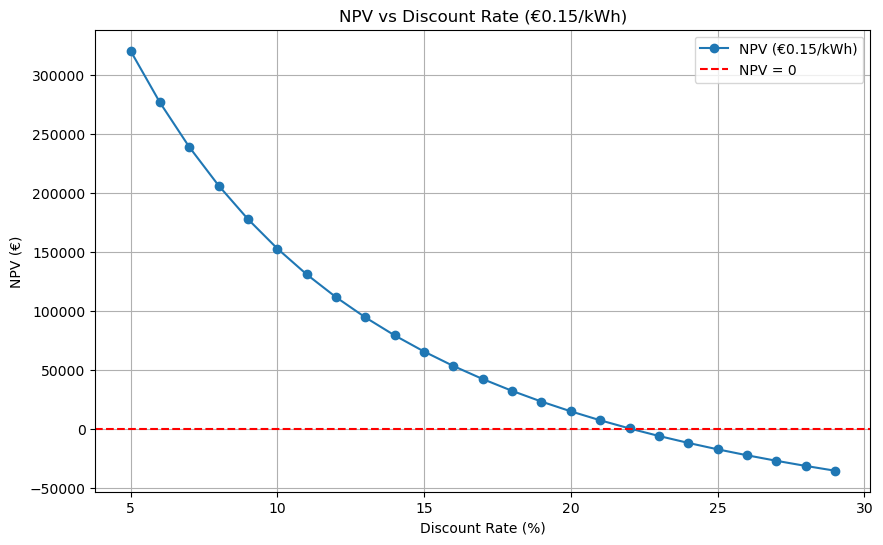

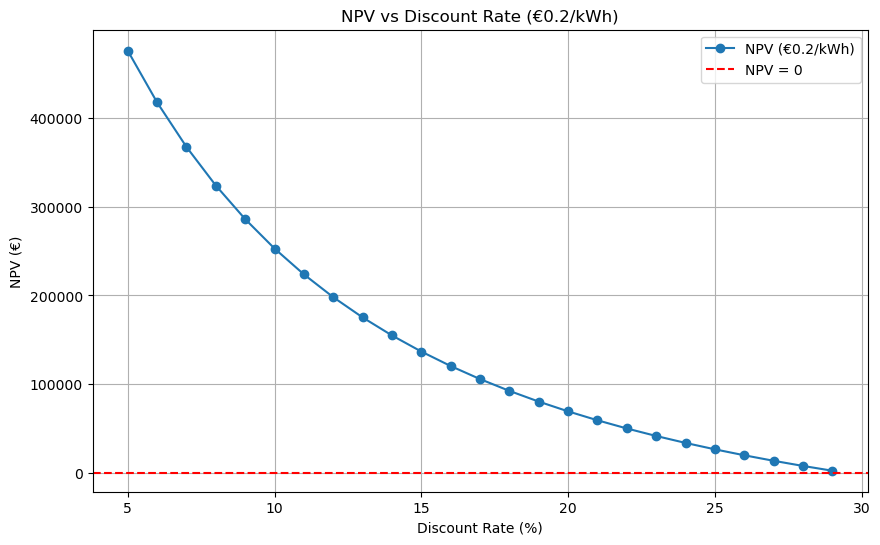

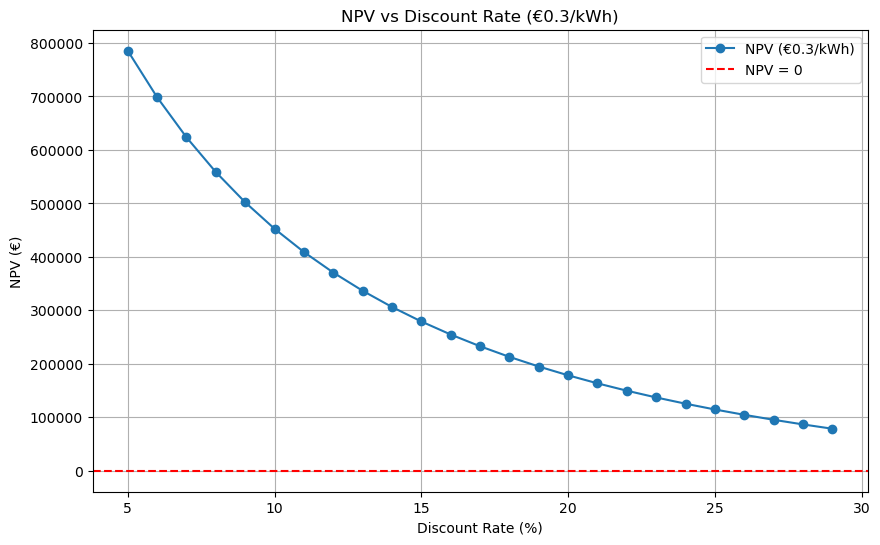

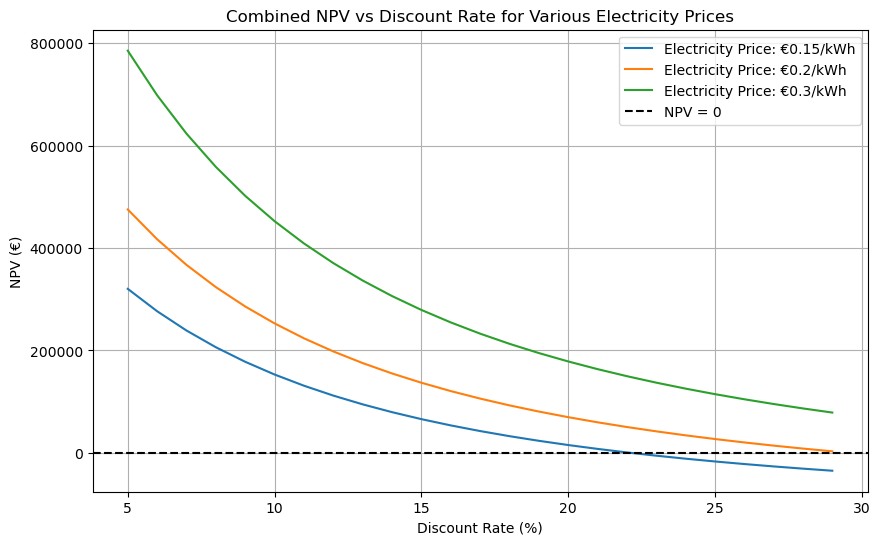

In [6]:
!pip install numpy-financial
import pandas as pd
import pandas as pd
import numpy as np
import numpy_financial as npf  # For financial functions like IRR
import os
import matplotlib.pyplot as plt

# Constants
electricity_prices = [0.15, 0.20, 0.3]  # €/kWh scenarios
grid_feed_in_rate = 0.04749  # €/kWh
investment_cost = -150000  # € initial investment (negative for NPV calculations)
lifespan_years = 25  # Project lifespan
degradation_rate = 0.005  # 0.5% annual degradation in PV production efficiency
discount_rates = np.arange(0.05, 0.30, 0.01)  # Discount rates from 5% to 29%
discount_rates_percent = discount_rates * 100

# Input Data
data = {
    "Month": [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    "Hotel Consumption (kWh)": [
        17621.84633, 23789.85092, 26021.50229, 130578.8417, 218748.2798,
        181708.4289, 190969.6101, 184752.2936, 181490.2523, 210015.195,
        19082.28211, 15160.55046
    ],
    "PV Production (kWh)": [
        5956.05, 14764.275, 20286.945, 24053.235, 25465.365, 28193.39273,
        29375.17676, 25788.62203, 20177.20945, 15467.26359, 9775.242188, 8621.484141
    ]
}

# Create a DataFrame for monthly data
df = pd.DataFrame(data)
self_consumption_ratios = [0.8] * 2 + [1] * 8 + [0.8] * 2
df["Self-Consumption Ratio"] = self_consumption_ratios
df["Self-Consumption (kWh)"] = df["PV Production (kWh)"] * df["Self-Consumption Ratio"]
df["Grid Feed (kWh)"] = df["PV Production (kWh)"] * (1 - df["Self-Consumption Ratio"])
df["Energy Covered by PV (kWh)"] = df[["Self-Consumption (kWh)", "Hotel Consumption (kWh)"]].min(axis=1)
df["Energy Bought from Grid (kWh)"] = df["Hotel Consumption (kWh)"] - df["Energy Covered by PV (kWh)"]

# Prepare outputs
results = {}
npv_vs_rate_plot_data = {}

# Process each electricity price scenario
for electricity_cost in electricity_prices:
    # Financial Calculations
    df["Savings (€)"] = df["Energy Covered by PV (kWh)"] * electricity_cost
    df["Feed-in Revenue (€)"] = df["Grid Feed (kWh)"] * grid_feed_in_rate
    df["Total Benefit (€)"] = df["Savings (€)"] + df["Feed-in Revenue (€)"]

    # Calculate annual cash flows
    annual_savings = df["Savings (€)"].sum()
    annual_feed_in_revenue = df["Feed-in Revenue (€)"].sum()
    annual_cash_flows = [investment_cost] + [
        annual_savings + annual_feed_in_revenue * ((1 - degradation_rate) ** year)
        for year in range(lifespan_years)
    ]

    # Print Cash Flows for the Scenario
    print(f"\nCash Flows for €{electricity_cost}/kWh:")
    for year, cash_flow in enumerate(annual_cash_flows):
        print(f"Year {year}: €{cash_flow:.2f}")

    # Calculate NPV for each discount rate
    npv_values = [
        npf.npv(rate, annual_cash_flows) for rate in discount_rates
    ]
    npv_vs_rate_plot_data[electricity_cost] = npv_values

    # Calculate IRR for the scenario
    irr = npf.irr(annual_cash_flows) * 100

    # Create Present Value Table
    pv_table = pd.DataFrame(index=range(lifespan_years + 1))
    for rate in discount_rates:
        pv_cash_flows = [cf / ((1 + rate) ** t) for t, cf in enumerate(annual_cash_flows, start=0)]
        pv_table[f"PV (rate={rate * 100:.1f}%)"] = pv_cash_flows
    pv_table["Cumulative PV"] = pv_table.sum(axis=1)

    # Plot NPV vs Discount Rate
    plt.figure(figsize=(10, 6))
    plt.plot(discount_rates_percent, npv_values, marker="o", label=f"NPV (€{electricity_cost}/kWh)")
    plt.axhline(0, color="r", linestyle="--", label="NPV = 0")
    plt.title(f"NPV vs Discount Rate (€{electricity_cost}/kWh)")
    plt.xlabel("Discount Rate (%)")
    plt.ylabel("NPV (€)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"NPV_vs_Discount_Rate_{electricity_cost}.png")

    # Print PV Table
    print(f"\nPresent Value (PV) Table for €{electricity_cost}/kWh:")
    print(pv_table)

    # Store results
    results[electricity_cost] = {
        "NPV (€)": npv_values,
        "IRR (%)": irr,
        "PV Table": pv_table
    }

# Plot combined NPV vs Discount Rate
plt.figure(figsize=(10, 6))
for electricity_cost, npv_values in npv_vs_rate_plot_data.items():
    plt.plot(
        discount_rates_percent,
        npv_values,
        label=f"Electricity Price: €{electricity_cost}/kWh",
    )
plt.axhline(0, color="black", linestyle="--", label="NPV = 0")
plt.title("Combined NPV vs Discount Rate for Various Electricity Prices")
plt.xlabel("Discount Rate (%)")
plt.ylabel("NPV (€)")
plt.legend()
plt.grid(True)
plt.savefig("Combined_NPV_vs_Discount_Rate.png")

# Create IRR summary table
irr_summary = pd.DataFrame({
    "Electricity Price (€/kWh)": electricity_prices,
    "IRR (%)": [results[price]["IRR (%)"] for price in electricity_prices],
})

# Save all results to an Excel file
file_path = "PV_Financial_Analysis_Scenarios.xlsx"

with pd.ExcelWriter(file_path) as writer:
    for price, result in results.items():
        df.to_excel(writer, sheet_name=f"Monthly_Analysis_{price}", index=False)
        result["PV Table"].to_excel(writer, sheet_name=f"PV_Table_{price}", index=False)
        pd.DataFrame({
            "Discount Rate (%)": discount_rates_percent,
            "NPV (€)": result["NPV (€)"],
        }).to_excel(writer, sheet_name=f"NPV_vs_Rate_{price}", index=False)
    irr_summary.to_excel(writer, sheet_name="IRR_Summary", index=False)

print("\nIRR Results for Different Scenarios:")
print(irr_summary)

# Process each electricity price scenario
for electricity_cost in electricity_prices:
    cumulative_cash_flows = {}
    break_even_years = []

    # Iterate through discount rates
    for discount_rate in discount_rates:
        # Financial Calculations
        df["Savings (€)"] = df["Energy Covered by PV (kWh)"] * electricity_cost
        df["Feed-in Revenue (€)"] = df["Grid Feed (kWh)"] * grid_feed_in_rate
        df["Total Benefit (€)"] = df["Savings (€)"] + df["Feed-in Revenue (€)"]

        # Calculate annual cash flows
        annual_savings = df["Savings (€)"].sum()
        annual_feed_in_revenue = df["Feed-in Revenue (€)"].sum()
        annual_cash_flows = [investment_cost] + [
            (annual_savings + annual_feed_in_revenue) / ((1 + discount_rate) ** year)
            for year in range(1, lifespan_years + 1)
        ]

        # Calculate cumulative cash flows
        cumulative_flow = np.cumsum(annual_cash_flows)
        cumulative_cash_flows[f"{discount_rate * 100:.1f}%"] = cumulative_flow

        # Identify break-even year
        break_even_year = next((year for year, value in enumerate(cumulative_flow) if value >= 0), None)
        break_even_years.append(break_even_year)

    # Plot cumulative cash flows for all discount rates
    plt.figure(figsize=(10, 6))
    for discount_rate, cash_flows in cumulative_cash_flows.items():
        plt.plot(range(len(cash_flows)), cash_flows, label=f"{discount_rate}")
    plt.axhline(0, color="red", linestyle="--", label="Break-even Line")
    plt.title(f"Cumulative Cash Flow for €{electricity_cost}/kWh")
    plt.xlabel("Year")
    plt.ylabel("Cumulative Cash Flow (€)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"Break_Even_Cash_Flow_{electricity_cost}.png")
    plt.show()

    # Create summary table
    summary_table = pd.DataFrame({
        "Discount Rate (%)": [f"{rate * 100:.1f}%" for rate in discount_rates],
        "Break-even Year": break_even_years
    })

    # Plot summary table as a figure
    plt.figure(figsize=(10, 4))
    plt.axis("off")
    table = plt.table(cellText=summary_table.values,
                      colLabels=summary_table.columns,
                      loc="center",
                      cellLoc="center")
    table.scale(1, 2)  # Adjust table size
    plt.title(f"Break-even Years for €{electricity_cost}/kWh")
    plt.savefig(f"Break_Even_Summary_Table_{electricity_cost}.png")
    plt.show()

print(f"\nAnalysis complete! Results and plots saved to: {file_path}")


In [7]:
import pandas as pd
import numpy as np
import numpy_financial as npf

# Constants
electricity_prices = [0.15, 0.2, 0.3]  # €/kWh scenarios
grid_feed_in_rate = 0.04749  # €/kWh
investment_cost = -150000  # € initial investment (negative for NPV calculations)
lifespan_years = 25  # Project lifespan
degradation_rate = 0.005  # 0.5% annual degradation in PV production efficiency

# Input Data
data = {
    "Month": [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    "Hotel Consumption (kWh)": [
        17621.84633, 23789.85092, 26021.50229, 130578.8417, 218748.2798,
        181708.4289, 190969.6101, 184752.2936, 181490.2523, 210015.195,
        19082.28211, 15160.55046
    ],
    "PV Production (kWh)": [
        5956.05, 14764.275, 20286.945, 24053.235, 25465.365, 28193.39273,
        29375.17676, 25788.62203, 20177.20945, 15467.26359, 9775.242188, 8621.484141
    ]
}

# Create a DataFrame for monthly data
df = pd.DataFrame(data)
self_consumption_ratios = [0.8] * 2 + [1] * 8 + [0.8] * 2
df["Self-Consumption Ratio"] = self_consumption_ratios
df["Self-Consumption (kWh)"] = df["PV Production (kWh)"] * df["Self-Consumption Ratio"]
df["Grid Feed (kWh)"] = df["PV Production (kWh)"] * (1 - df["Self-Consumption Ratio"])
df["Energy Covered by PV (kWh)"] = df[["Self-Consumption (kWh)", "Hotel Consumption (kWh)"]].min(axis=1)
df["Energy Bought from Grid (kWh)"] = df["Hotel Consumption (kWh)"] - df["Energy Covered by PV (kWh)"]

# Prepare outputs
results = {}

# Process each electricity price scenario
for electricity_cost in electricity_prices:
    # Financial Calculations
    df["Savings (€)"] = df["Energy Covered by PV (kWh)"] * electricity_cost
    df["Feed-in Revenue (€)"] = df["Grid Feed (kWh)"] * grid_feed_in_rate
    df["Total Benefit (€)"] = df["Savings (€)"] + df["Feed-in Revenue (€)"]

    # Calculate annual cash flows
    annual_savings = df["Savings (€)"].sum()
    annual_feed_in_revenue = df["Feed-in Revenue (€)"].sum()
    annual_cash_flows = [investment_cost] + [
        annual_savings + annual_feed_in_revenue * ((1 - degradation_rate) ** year)
        for year in range(lifespan_years)
    ]

    # Calculate cumulative cash flows
    cumulative_cash_flows = np.cumsum(annual_cash_flows)

    # Find the break-even year
    break_even_year = None
    for year, cash_flow in enumerate(cumulative_cash_flows):
        if cash_flow >= 0:
            break_even_year = year
            break

    # Print break-even analysis
    print(f"\nBreak-even Analysis for €{electricity_cost}/kWh:")
    if break_even_year is not None:
        print(f"Break-even Year: Year {break_even_year}")
    else:
        print("Break-even Year: Not achieved within project lifespan.")
    print("Cumulative Cash Flows:")
    print(cumulative_cash_flows)

    # Store results
    results[electricity_cost] = {
        "Break-even Year": break_even_year,
        "Cumulative Cash Flows": cumulative_cash_flows.tolist(),
    }

# Save results to an Excel file
file_path = "PV_Break_Even_Analysis.xlsx"

with pd.ExcelWriter(file_path) as writer:
    for price, result in results.items():
        pd.DataFrame({
            "Year": range(len(result["Cumulative Cash Flows"])),
            "Cumulative Cash Flow (€)": result["Cumulative Cash Flows"],
        }).to_excel(writer, sheet_name=f"Break-even_{price}", index=False)

print(f"\nBreak-even analysis complete! Results saved to: {file_path}")



Break-even Analysis for €0.15/kWh:
Break-even Year: Year 5
Cumulative Cash Flows:
[-150000.         -116613.338653    -83228.53497476  -49845.57967695
  -16464.46351766   16914.8226988    50292.28812215   83667.94185634
  117041.79295984  150413.85044578  183784.12328226  217152.62039252
  250519.35065521  283884.32290454  317247.5459306   350609.02847949
  383968.77925361  417326.80691182  450683.12006971  484037.72729978
  517390.63713166  550741.85805235  584091.39850641  617439.26689616
  650785.47158194  684130.02088225]

Break-even Analysis for €0.2/kWh:
Break-even Year: Year 4
Cumulative Cash Flows:
[-150000.         -105608.29612184  -61218.44991244  -16830.45208347
   27555.70660698   71940.0353546   116322.54330911  160703.23957446
  205082.13320912  249459.23322622  293834.54859386  338208.08823528
  382579.86102913  426949.87580962  471318.14136684  515684.66644689
  560049.45975217  604412.52994154  648773.88563059  693133.53539182
  737491.48775486  781847.75120672  8262

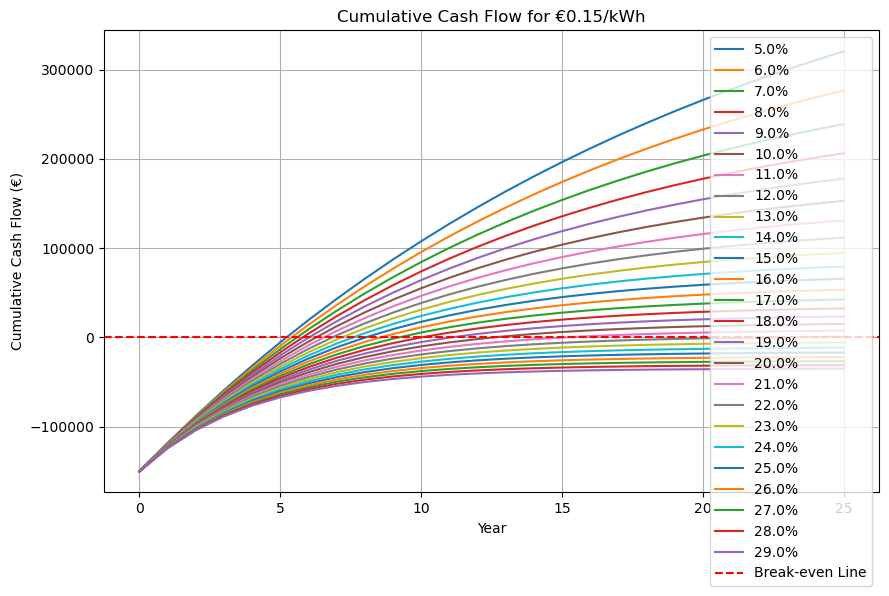

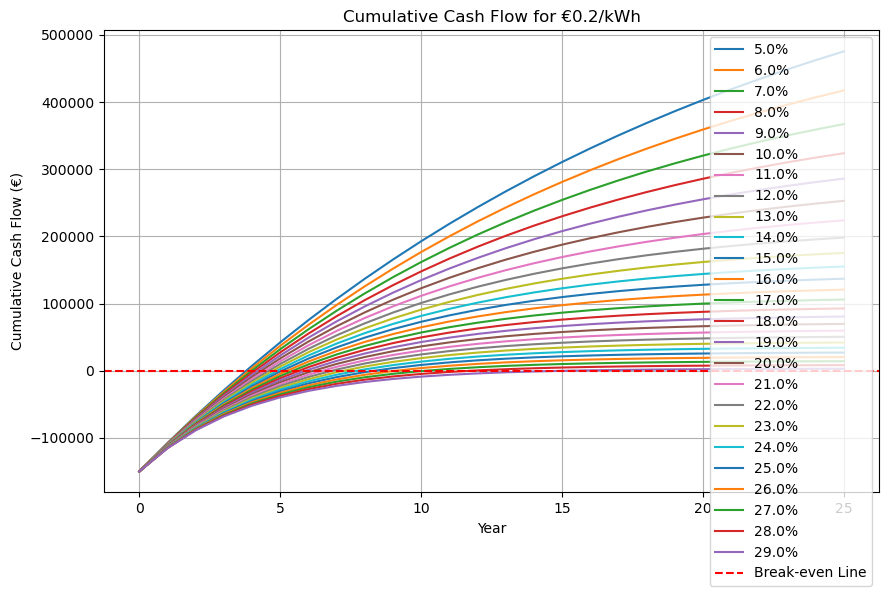

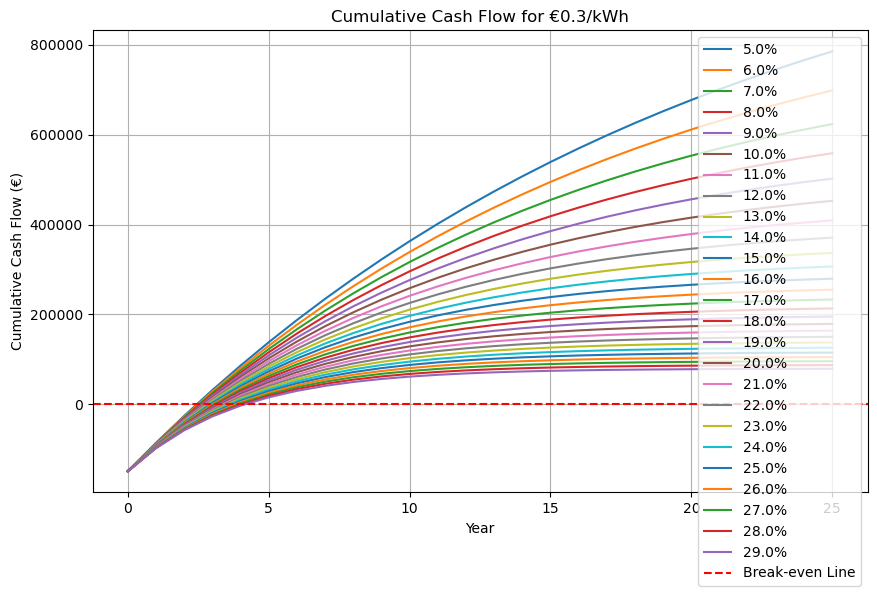

Break-even analysis complete! Results saved to Break_Even_Analysis.xlsx


In [11]:
import pandas as pd
import numpy as np
import numpy_financial as npf  # For financial functions like IRR
import matplotlib.pyplot as plt

# Constants
electricity_prices = [0.15, 0.2, 0.3]  # €/kWh scenarios
grid_feed_in_rate = 0.04749  # €/kWh
investment_cost = -150000  # € initial investment (negative for NPV calculations)
lifespan_years = 25  # Project lifespan
degradation_rate = 0.005  # 0.5% annual degradation in PV production efficiency
discount_rates = np.arange(0.05, 0.30, 0.01)  # Discount rates from 5% to 29%

# Input Data
data = {
    "Month": [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    "Hotel Consumption (kWh)": [
        17621.84633, 23789.85092, 26021.50229, 130578.8417, 218748.2798,
        181708.4289, 190969.6101, 184752.2936, 181490.2523, 210015.195,
        19082.28211, 15160.55046
    ],
    "PV Production (kWh)": [
        5956.05, 14764.275, 20286.945, 24053.235, 25465.365, 28193.39273,
        29375.17676, 25788.62203, 20177.20945, 15467.26359, 9775.242188, 8621.484141
    ]
}

# Create DataFrame for monthly data
df = pd.DataFrame(data)
self_consumption_ratios = [0.8] * 2 + [1] * 8 + [0.8] * 2
df["Self-Consumption Ratio"] = self_consumption_ratios
df["Self-Consumption (kWh)"] = df["PV Production (kWh)"] * df["Self-Consumption Ratio"]
df["Grid Feed (kWh)"] = df["PV Production (kWh)"] * (1 - df["Self-Consumption Ratio"])
df["Energy Covered by PV (kWh)"] = df[["Self-Consumption (kWh)", "Hotel Consumption (kWh)"]].min(axis=1)
df["Energy Bought from Grid (kWh)"] = df["Hotel Consumption (kWh)"] - df["Energy Covered by PV (kWh)"]

# Excel file to save results
output_file = "Break_Even_Analysis.xlsx"

# Process each electricity price scenario
with pd.ExcelWriter(output_file) as writer:
    for electricity_cost in electricity_prices:
        cumulative_cash_flows = {}
        break_even_years = []

        # Iterate through discount rates
        for discount_rate in discount_rates:
            # Financial Calculations
            df["Savings (€)"] = df["Energy Covered by PV (kWh)"] * electricity_cost
            df["Feed-in Revenue (€)"] = df["Grid Feed (kWh)"] * grid_feed_in_rate
            df["Total Benefit (€)"] = df["Savings (€)"] + df["Feed-in Revenue (€)"]

            # Calculate annual cash flows
            annual_savings = df["Savings (€)"].sum()
            annual_feed_in_revenue = df["Feed-in Revenue (€)"].sum()
            annual_cash_flows = [investment_cost] + [
                (annual_savings + annual_feed_in_revenue) / ((1 + discount_rate) ** year)
                for year in range(1, lifespan_years + 1)
            ]

            # Calculate cumulative cash flows
            cumulative_flow = np.cumsum(annual_cash_flows)
            cumulative_cash_flows[f"{discount_rate * 100:.1f}%"] = cumulative_flow

            # Identify break-even year
            break_even_year = next((year for year, value in enumerate(cumulative_flow) if value >= 0), None)
            break_even_years.append(break_even_year)

        # Create summary table
        summary_table = pd.DataFrame({
            "Discount Rate (%)": [f"{rate * 100:.1f}%" for rate in discount_rates],
            "Break-even Year": break_even_years
        })

        # Save data to Excel
        cumulative_df = pd.DataFrame(cumulative_cash_flows)
        cumulative_df.to_excel(writer, sheet_name=f"Cash Flow €{electricity_cost}", index=False)
        summary_table.to_excel(writer, sheet_name=f"Break-even €{electricity_cost}", index=False)

        # Plot cumulative cash flows for all discount rates
        plt.figure(figsize=(10, 6))
        for discount_rate, cash_flows in cumulative_cash_flows.items():
            plt.plot(range(len(cash_flows)), cash_flows, label=f"{discount_rate}")
        plt.axhline(0, color="red", linestyle="--", label="Break-even Line")
        plt.title(f"Cumulative Cash Flow for €{electricity_cost}/kWh")
        plt.xlabel("Year")
        plt.ylabel("Cumulative Cash Flow (€)")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"Break_Even_Cash_Flow_{electricity_cost}.png")
        plt.show()

print(f"Break-even analysis complete! Results saved to {output_file}")


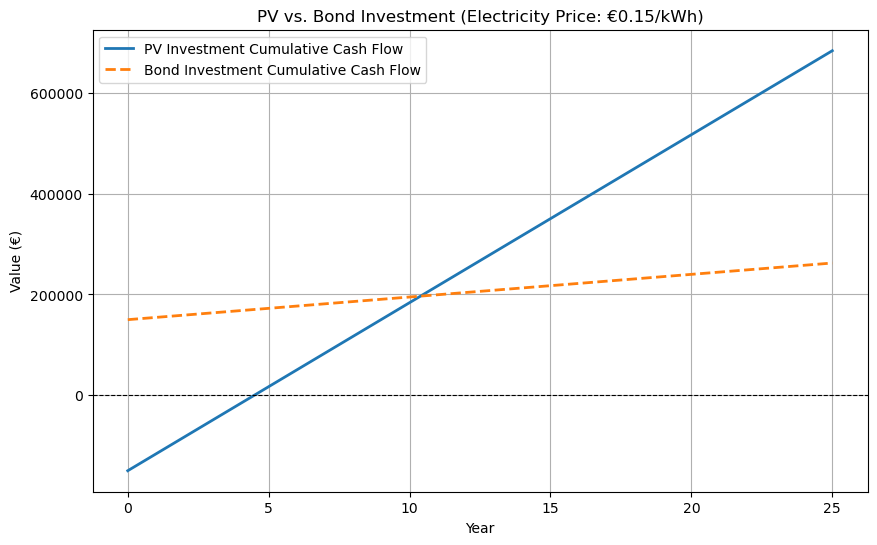

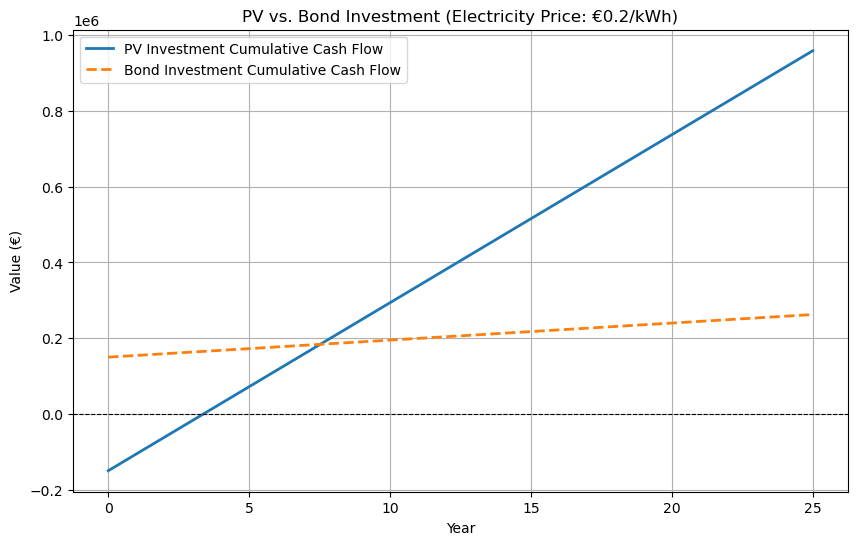

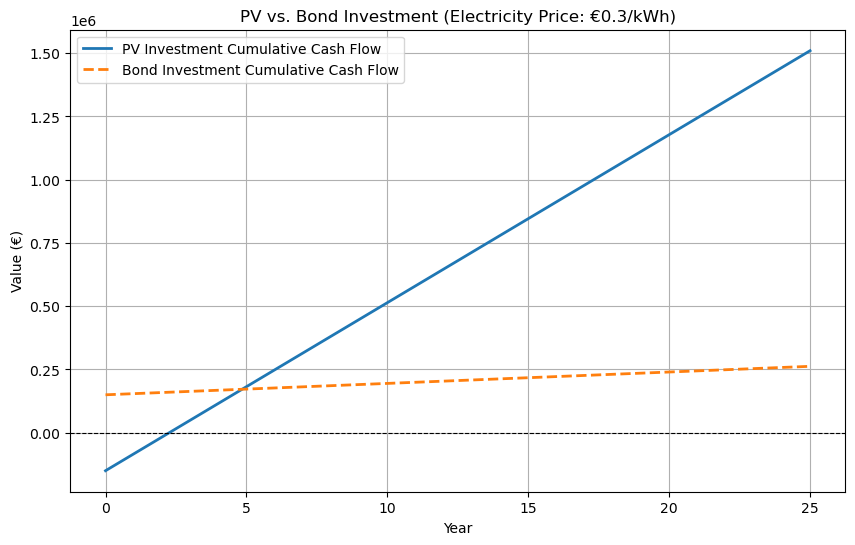


Analysis complete! Results saved to: C:\Users\vasil\Downloads\PV_vs_Bond_Investment_All_Prices.xlsx


In [12]:
# Input Data
data = {
    "Month": [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    "Hotel Consumption (kWh)": [
        17621.84633, 23789.85092, 26021.50229, 130578.8417, 218748.2798,
        181708.4289, 190969.6101, 184752.2936, 181490.2523, 210015.195,
        19082.28211, 15160.55046
    ],
    "PV Production (kWh)": [
        5956.05, 14764.275, 20286.945, 24053.235, 25465.365, 28193.39273,
        29375.17676, 25788.62203, 20177.20945, 15467.26359, 9775.242188, 8621.484141
    ]
}

# Constants
electricity_prices = [0.15, 0.20, 0.30]  # €/kWh
grid_feed_in_rate = 0.04749  # €/kWh
investment_cost = -150000  # € initial investment (negative for NPV calculations)
lifespan_years = 25  # Project lifespan
degradation_rate = 0.005  # 0.5% annual degradation in PV production efficiency
discount_rates = np.arange(0.05, 0.30, 0.01)  # Discount rates from 5% to 29%
bond_yield = 0.03  # 3% annual bond yield (opportunity cost)

# Prepare results for multiple electricity prices
all_results = {}

for electricity_cost in electricity_prices:
    # Create DataFrame
    df = pd.DataFrame(data)
    self_consumption_ratios = [0.8] * 2 + [1] * 8 + [0.8] * 2
    df["Self-Consumption Ratio"] = self_consumption_ratios
    df["Self-Consumption (kWh)"] = df["PV Production (kWh)"] * df["Self-Consumption Ratio"]
    df["Grid Feed (kWh)"] = df["PV Production (kWh)"] * (1 - df["Self-Consumption Ratio"])
    df["Energy Covered by PV (kWh)"] = df[["Self-Consumption (kWh)", "Hotel Consumption (kWh)"]].min(axis=1)
    df["Energy Bought from Grid (kWh)"] = df["Hotel Consumption (kWh)"] - df["Energy Covered by PV (kWh)"]

    # Financial Calculations for PV
    df["Savings (€)"] = df["Energy Covered by PV (kWh)"] * electricity_cost
    df["Feed-in Revenue (€)"] = df["Grid Feed (kWh)"] * grid_feed_in_rate
    df["Total Benefit (€)"] = df["Savings (€)"] + df["Feed-in Revenue (€)"]

    # Calculate annual cash flows
    annual_savings = df["Savings (€)"].sum()
    annual_feed_in_revenue = df["Feed-in Revenue (€)"].sum()
    annual_cash_flows = [
        annual_savings + annual_feed_in_revenue * ((1 - degradation_rate) ** year)
        for year in range(lifespan_years)
    ]

    # NPV and IRR Calculations for PV
    npv_values = [npf.npv(rate, [investment_cost] + annual_cash_flows) for rate in discount_rates]
    irr_pv = npf.irr([investment_cost] + annual_cash_flows) * 100

    # Bond Investment Calculations
    bond_cash_flows = [-investment_cost] + [
        -investment_cost * bond_yield for _ in range(1, lifespan_years + 1)
    ]
    bond_npvs = [npf.npv(rate, bond_cash_flows) for rate in discount_rates]

    # Opportunity Cost Calculation
    opportunity_costs = [bond - pv for bond, pv in zip(bond_npvs, npv_values)]

    # Cumulative Cash Flow Calculations
    years = np.arange(0, lifespan_years + 1)
    pv_cumulative_cash_flows = np.cumsum([investment_cost] + annual_cash_flows)
    bond_cumulative_cash_flows = np.cumsum(bond_cash_flows)

    # Store results
    all_results[electricity_cost] = {
        "PV Cumulative Cash Flows (€)": pv_cumulative_cash_flows,
        "Bond Cumulative Cash Flows (€)": bond_cumulative_cash_flows,
        "NPV Comparison": pd.DataFrame({
            "Discount Rate (%)": discount_rates * 100,
            "NPV PV (€)": npv_values,
            "NPV Bond (€)": bond_npvs,
            "Opportunity Cost (€)": opportunity_costs,
        })
    }

    # Plot Comparison
    plt.figure(figsize=(10, 6))
    plt.plot(years, pv_cumulative_cash_flows, label="PV Investment Cumulative Cash Flow", linewidth=2)
    plt.plot(years, bond_cumulative_cash_flows, label="Bond Investment Cumulative Cash Flow", linestyle="--", linewidth=2)
    plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
    plt.xlabel("Year")
    plt.ylabel("Value (€)")
    plt.title(f"PV vs. Bond Investment (Electricity Price: €{electricity_cost}/kWh)")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"PV_vs_Bond_Investment_{electricity_cost:.2f}_Comparison.png")
    plt.show()

# Save All Results to Excel
downloads_folder = os.path.join(os.path.expanduser("~"), "Downloads")
file_path = os.path.join(downloads_folder, "PV_vs_Bond_Investment_All_Prices.xlsx")

with pd.ExcelWriter(file_path) as writer:
    for price, results in all_results.items():
        comparison_df = results["NPV Comparison"]
        comparison_df.to_excel(writer, sheet_name=f"NPV_Comparison_{price:.2f}", index=False)

print(f"\nAnalysis complete! Results saved to: {file_path}")
